In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2, json, torch, os, re

import util, constants, draw, cam, model, loader, img_proc

np.random.seed(0)
torch.manual_seed(0)

VID_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/harden/'
DATA_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/'

img_shape_yx = plt.imread(VID_ROOT+'/all_views/frame_00001.png').shape[:2];img_shape_xy = img_shape_yx[::-1]

uf_mat_int_default = cam.get_mat_intrinsic()
uf_mat_int = cam.get_intrinsic_mat_for_img_shape(img_shape_xy)

with open(VID_ROOT+'/md.json') as f:
    data = json.load(f)
    num_views, num_frames = data['num_views'], data['num_frames']
    
print(f'{num_views} views, {num_frames} frames')
print(f'img_shape_xy: {img_shape_xy}')

3 views, 90 frames
img_shape_xy: (1280, 720)


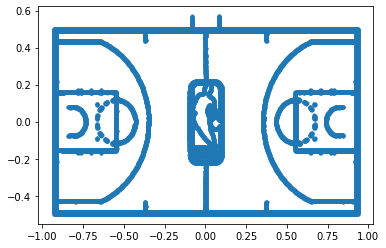

In [4]:
img = plt.imread(VID_ROOT+'/view_0/frame_00089.png')
img = (img*255/img.max()).astype(np.uint8)

court_img, court_bin = model.load_model_img(DATA_ROOT)
court_img = (court_img*255/court_img.max()).astype(np.uint8)

mat_model = model.get_mat_model(model.load_model_corners(DATA_ROOT))

X_w = model.calc_model_world_coordinates(DATA_ROOT)
plt.scatter(X_w[:, 0], X_w[:, 1], marker='.');plt.show()

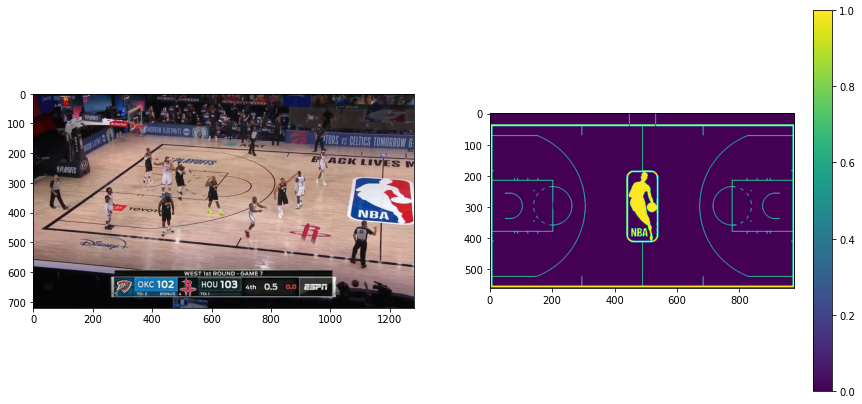

In [5]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(court_bin);plt.colorbar();plt.show()

In [6]:
import json
import numpy as np
with open('/home/akarshkumar0101/nba-3d-data/harden/init_views.json') as f:
    data = json.load(f)
data = np.array(data)
# keypoint correspondance data
# data has shape [view, {image/model}, 4, {x, y}]
print(data.shape)

(3, 2, 4, 2)


# Homography

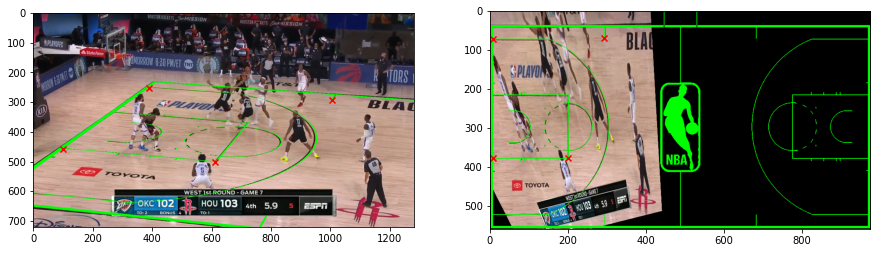

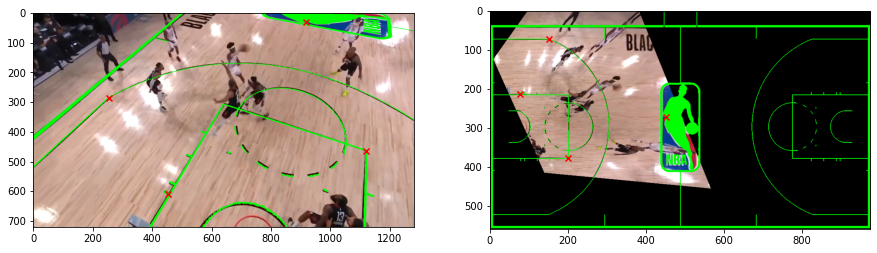

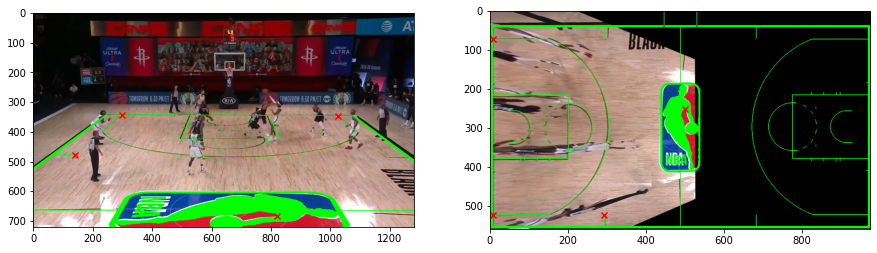

In [10]:
for view_idx in range(3):
    img = plt.imread(VID_ROOT+f'/view_{view_idx}/frame_00000.png')
    img = (img*255/img.max()).astype(np.uint8)
    src = data[view_idx, 0]
    dst = data[view_idx, 1]
    H, _ = cv2.findHomography(src, dst, )

    plt.figure(figsize=(15,7))
    plt.subplot(121)
    courtt = cv2.warpPerspective(court_img, H, dsize=img.shape[:2][::-1], flags=cv2.WARP_INVERSE_MAP)
    courtt = courtt[..., :3].mean(axis=-1)>180
    imgt = img.copy()
    imgt[courtt, :] = 0.
    imgt[courtt, 1] = 255.
    imgt = np.clip(imgt, 0, 255)
    plt.scatter(src[:, 0], src[:, 1], marker='x', c='r')
    plt.imshow(imgt)
    
    plt.subplot(122)
    imgt = cv2.warpPerspective(img, H, dsize=court_img.shape[:2][::-1])
    imgt[court_bin, :] = 0.
    imgt[court_bin, 1] = 255.
    imgt = np.clip(imgt, 0, 255)
    plt.scatter(dst[:, 0], dst[:, 1], marker='x', c='r')
    plt.imshow(imgt)
    
    plt.show()
    

# Perspective N Point

In [6]:
def find_cv2_RT(f, X_i_kp, X_w_kp):
    mat_int = cam.apply_focus(f, uf_mat_int)[:, :3]
    
    retval, R, T = cv2.solvePnP(X_w_kp, X_i_kp, mat_int, np.zeros((4,1)), flags=cv2.SOLVEPNP_IPPE)
    R, _ = cv2.Rodrigues(R)
    # this returns R, T such that mat_int@(R@X_w+T) ~= X_i
    
    X_c_kp = (R@X_w_kp[..., None])+T
    X_i_kp_reproj = mat_int[:, :3]@X_c_kp
    X_i_kp_reproj = util.from_homo(X_i_kp_reproj[..., 0])
    
    return R, T, X_i_kp_reproj

def calc_dofs_cam_from_cv2_RT(R, T, f):
    dofs_cam = torch.zeros(7)
    dofs_cam[:3] = torch.from_numpy(-np.linalg.inv(R)@T[..., 0])
    dofs_cam[3:6] = util.so3_log_map(torch.from_numpy(np.linalg.inv(R)))
    dofs_cam[6] = np.log(f)
    return dofs_cam

def calc_dofs_cam_from_kp(X_i_kp, X_w_kp):
    fits = []
    fs = np.logspace(-2, 3, base=np.e, num=500)
    for f in fs: # grid search over focal lengths
        R, T, X_i_kp_reproj = find_cv2_RT(f, X_i_kp, X_w_kp)
        fit = np.linalg.norm(X_i_kp-X_i_kp_reproj, axis=-1).mean()
        fits.append(fit)
    f = fs[np.argmin(fits)]
    print(f'focal length: {f: 0.04f}, mean dist: {np.min(fits): 0.04f}')
    R, T, X_i_kp_reproj = find_cv2_RT(f, X_i_kp, X_w_kp)
    dofs_cam = calc_dofs_cam_from_cv2_RT(R, T, f)
    return dofs_cam, X_i_kp_reproj

dofs_cams = []
X_i_kp_reprojs = []
X_i_kps = []
for view_idx in range(3):
    X_i_kp = data[view_idx, 0].astype(np.float64)
    X_m_kp = data[view_idx, 1].astype(np.float64)
    X_m_kp = np.concatenate([X_m_kp, np.zeros((len(X_m_kp), 1))], axis=-1)
    X_w_kp = util.from_homo((mat_model@util.to_homo(X_m_kp)[..., None])[..., 0])
    
    dofs_cam, X_i_kp_reproj = calc_dofs_cam_from_kp(X_i_kp, X_w_kp)
    
    dofs_cams.append(dofs_cam)
    X_i_kps.append(X_i_kp)
    X_i_kp_reprojs.append(X_i_kp_reproj)
    
dofs_cam = torch.stack(dofs_cams)[:, None, :]

focal length:  4.3359, mean dist:  1.0037
focal length:  1.0662, mean dist:  0.8370
focal length:  2.3064, mean dist:  1.0630


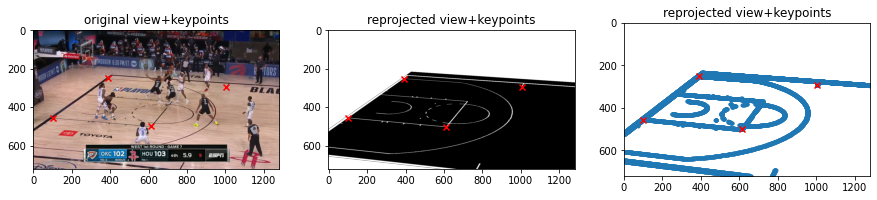

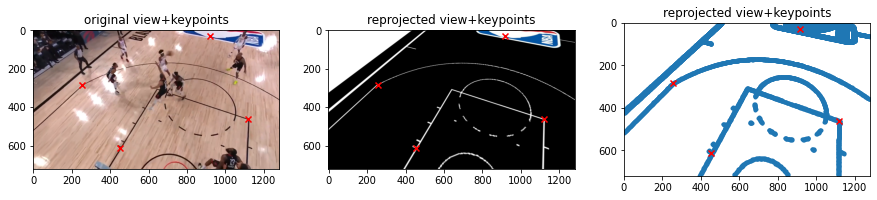

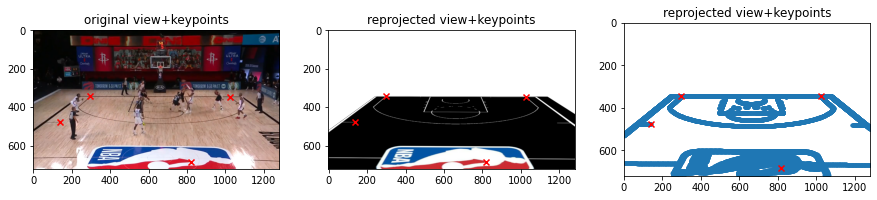

In [7]:
imgs = cam.calc_perspective_image(court_img, dofs_cam, mat_model, img_shape_xy)
for view_idx in range(3):
    draw.plt_figure_aspect_ratio((img_shape_xy[0]*3,img_shape_xy[1]), 15)
    plt.subplot(131)
    plt.imshow(plt.imread(VID_ROOT+f'/view_{view_idx}/frame_00000.png'))
    plt.scatter(X_i_kps[view_idx][:, 0], X_i_kps[view_idx][:, 1], marker='x', c='r')
    plt.title('original view+keypoints')
    
    plt.subplot(132)
    plt.imshow(imgs[view_idx, 0])
    plt.scatter(X_i_kp_reprojs[view_idx][:, 0], X_i_kp_reprojs[view_idx][:, 1], marker='x', c='r')
    plt.title('reprojected view+keypoints')
    
    plt.subplot(133)
    draw.show_cam_view(X_w, dofs_cam[view_idx, 0], img_shape_xy)
    plt.scatter(X_i_kp_reprojs[view_idx][:, 0], X_i_kp_reprojs[view_idx][:, 1], marker='x', c='r')
    plt.title('reprojected view+keypoints')
        
    plt.show()

In [8]:
np.save(VID_ROOT+'/dofs_cam_first_frame', dofs_cam.numpy())

s[3,1] = [3x4]@[4x4]@[4,1]

s[3,1] = [3x4]@[4x4]@[4,1]